In [1]:
import json
import pathlib
import pycolmap
import datetime
import random

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import RandomSampler, DataLoader

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pyvista as pv

import neural_orientation_field.utils as utils
import neural_orientation_field.colmap.colmap_utils as colutils
from neural_orientation_field.nerf.dataset import NeRFImageDataset, NeRFRayDataset
from neural_orientation_field.nerf.model import NerfModel
from neural_orientation_field.nerf.utils import pos_encode, volumetric_renderer

In [2]:
# Seed rng for reproducability
np.random.seed(42)
torch.manual_seed(42)

# Load Dataset

In [3]:
# Neural Orientation Field config
IMAGE_PATH = "../data/images/hoover-tower-low-res/"
COLMAP_MODEL_PATH = "../data/output/colmap/model/0/"

image_dir = pathlib.Path(IMAGE_PATH).resolve()
colmap_model_path = pathlib.Path(COLMAP_MODEL_PATH).resolve()

image_dir, colmap_model_path

(PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/images/hoover-tower-low-res'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/output/colmap/model/0'))

In [4]:
image_dataset = NeRFImageDataset(image_dir, colmap_model_path)
image, f, cam_transform, cam_transform_inv, cam_orig, cam_ray_world = image_dataset[0]
image.shape, f.shape, cam_transform.shape, cam_transform_inv.shape, cam_orig.shape, cam_ray_world.shape

((256, 256, 3), (), (4, 4), (4, 4), (3,), (256, 256, 3))

In [5]:
with tqdm(total=len(image_dataset), desc="Processing Image") as progress:
    ray_dataset = NeRFRayDataset(image_dataset, progress)

Processing Image:   0%|          | 0/200 [00:00<?, ?it/s]

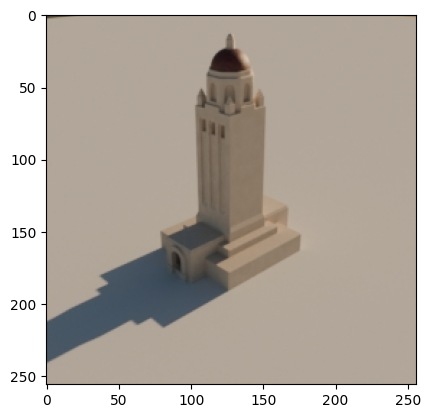

In [6]:
idx = 0
image, _, _, _, _, _ = image_dataset[idx]
plt.imshow(image)

In [7]:
num_random_rays = 32
origins = np.zeros((num_random_rays, 3))
directions = np.zeros((num_random_rays, 3))
colors = np.zeros((num_random_rays, 3))
for i in range(num_random_rays):
    ray_idx = random.randint(0, len(ray_dataset))
    origin, direction, color = ray_dataset[ray_idx]
    origins[i] = origin
    directions[i] = direction
    colors[i] = color
origins.shape, directions.shape, colors.shape

((32, 3), (32, 3), (32, 3))

# NeRF

In [8]:
# Use MPS device.
USE_DEVICE = "mps"

if USE_DEVICE == "mps" and torch.mps.is_available():
    device = torch.device("mps")
elif USE_DEVICE == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

# NeRF Training

In [9]:
# Near/far clipping distance.
nc = 1
fc = 8
# Positional encoding number.
num_pos_encode = 4
samples_per_ray = 16
# Hyper parameters.
lr = 5e-5
num_iters = 8
ray_batch_size = 16384
# Training settings.
size_train_ray = 1

# Init model.
model = NerfModel(num_encoding_functions=num_pos_encode)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
# Show volumetric rendering.
def render_nerf_eval(idx = -1):
    image_eval, _, _, _, cam_orig_eval, cam_ray_eval = image_dataset[idx]
    image_eval = torch.from_numpy(image_eval).type(torch.float32).to(device)
    cam_orig_eval = torch.from_numpy(cam_orig_eval).type(torch.float32).to(device)
    cam_orig_eval = cam_orig_eval.view(1, 1, -1)
    cam_orig_eval = cam_orig_eval.expand(image_eval.shape)
    cam_ray_eval = torch.from_numpy(cam_ray_eval).type(torch.float32).to(device)
    color_pred = volumetric_renderer(
        model,
        cam_orig_eval.reshape(-1, 3),
        cam_ray_eval.reshape(-1, 3),
        nc,
        fc,
        num_sample=samples_per_ray,
        num_pos_encode=num_pos_encode,
        device=device
    )
    image_pred = color_pred.reshape(image_eval.shape)
    return image_eval, image_pred

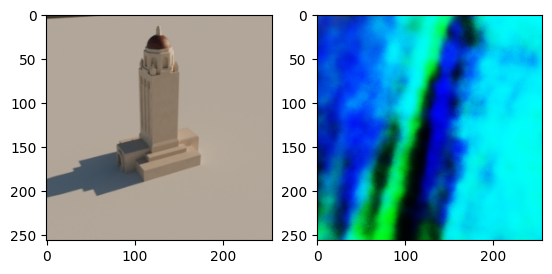

In [11]:
model.eval()
image_eval, image_pred = render_nerf_eval(-1)
fig, (ax_image, ax_pred) = plt.subplots(1, 2)
ax_image.imshow(image_eval.cpu())
ax_pred.imshow(image_pred.detach().cpu())

In [12]:
model.train()

train_sampler = RandomSampler(data_source=ray_dataset, num_samples=int(size_train_ray * len(ray_dataset)))
dataloader = DataLoader(
    ray_dataset,
    sampler=train_sampler,
    batch_size=ray_batch_size,
)

writer = SummaryWriter(flush_secs=1)
save_image_every_n_batch = 200
for it in tqdm(range(num_iters)):
    # One iteration of the training.
    for batch_i, (cam_orig_batch, cam_ray_batch, color_batch) in enumerate(tqdm(dataloader)):
        cam_orig_batch = cam_orig_batch.type(torch.float32).to(device)
        cam_ray_batch = cam_ray_batch.type(torch.float32).to(device)
        color_batch = color_batch.type(torch.float32).to(device)
        color_pred = volumetric_renderer(
            model,
            cam_orig_batch.reshape(-1, 3),
            cam_ray_batch.reshape(-1, 3),
            nc,
            fc,
            num_sample=samples_per_ray,
            num_pos_encode=num_pos_encode,
            device=device
        )
        loss = torch.nn.functional.mse_loss(color_pred, color_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        writer.add_scalar("MSE Loss", loss, (it * len(dataloader) + batch_i) * ray_batch_size)
        if batch_i % save_image_every_n_batch == 0:
            model.eval()
            image_eval, image_pred = render_nerf_eval(-1)
            writer.add_image("Eval Image", image_eval, (it * len(dataloader) + batch_i) * ray_batch_size, dataformats="HWC")
            writer.add_image("Pred Image", image_pred, (it * len(dataloader) + batch_i) * ray_batch_size, dataformats="HWC")
            model.train()
writer.close()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

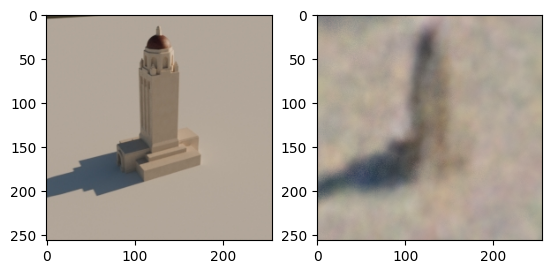

In [18]:
image_eval, image_pred = render_nerf_eval(-1)
fig, (ax_image, ax_pred) = plt.subplots(1, 2)
ax_image.imshow(image_eval.cpu())
ax_pred.imshow(image_pred.detach().cpu())